## EDA

Deep dive in data for better understanding

In [3]:
import gc 
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')
from utils import get_count_or_frac_duplicated_rows, plot_barplot_cancelation_by_agg_cols, plot_seasonal_decomposition

pd.set_option('display.max_columns', 500)
sns.set(style='darkgrid')

In [4]:
#constants
PATH_TO_DATA = os.path.join('data', 'hotel_bookings.csv')

In [5]:
df = (pd
      .read_csv(PATH_TO_DATA)
      .sort_values('arrival_date', ascending=True)
     )
uniq_hotels = df['hotel'].unique()
print(f'Input df shape: {df.shape}')
print(f'Cnt full duplicated rows: {get_count_or_frac_duplicated_rows(df, is_cnt=True)}')
print(f'Frac of duplicated rows: {get_count_or_frac_duplicated_rows(df, is_fraq=True)}')
#check dtypes (because maybe we need to change string to datetime type or smth like this)
#print(df.dtypes)
df.head(3)

Input df shape: (119390, 34)
Cnt full duplicated rows: 31994
Frac of duplicated rows: 0.268


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,year_month
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01
89,Resort Hotel,0,118,2015,July,27,1,4,10,2,0.0,0,BB,NaN,Direct,Direct,0,0,0,E,E,3,No Deposit,NaN,NaN,0,Transient,80.0,1,1,Check-Out,2015-07-15,2015-07-01,2015-07-01
88,Resort Hotel,0,4,2015,July,27,1,0,1,1,0.0,0,BB,NaN,Corporate,Corporate,0,0,4,A,C,0,No Deposit,NaN,204.0,0,Transient,134.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-07-01


We see that there're almost 32k duplicated rows that's about quarter of input dataframe

lead_time - Number of days that elapsed between the entering date of the booking into the PMS and the arrival date.

So we can get booking date.

It's a good question to choose which date must be used for sorting booking_date or arrival_date but it depends on business model and getting or not getting money by hotels for cancelled transactions. Anyway we are sure that hotels get money for non-cancelled booking transactions so in general it's better to use arrival_date for sorting to predict 6-month revenue of hotels (see the conclusion 3 below for more info) considering that hotels get money in a month where reservations are made

In [4]:
#getting booking date
df['arrival_date'] = pd.to_datetime(df['arrival_date']).apply(lambda x: x.date())
df['booking_date'] = df['arrival_date'] - pd.to_timedelta(df['lead_time'])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1268: PerformanceWarning: Adding/subtracting array of DateOffsets to TimedeltaArray not vectorized
  PerformanceWarning,


I would start checking columns more properly: uniq values, statistics to drop some bad things at first

In [5]:
cat_cols = [col for col, t in zip(df.dtypes.index, df.dtypes.values) if 'obj' in str(t)]
print('count uniq values')
for col in cat_cols:
    print(f"'{col}': {df[col].unique().shape[0]}")

count uniq values
'hotel': 2
'arrival_date_month': 12
'meal': 5
'country': 178
'market_segment': 8
'distribution_channel': 5
'reserved_room_type': 10
'assigned_room_type': 12
'deposit_type': 3
'customer_type': 4
'reservation_status': 3
'reservation_status_date': 926
'arrival_date': 793
'year_month': 26
'booking_date': 794


In [6]:
for col in cat_cols:
    if df[col].unique().shape[0] < 15:
        print(f"'{col}': {df[col].unique()}")

'hotel': ['Resort Hotel' 'City Hotel']
'arrival_date_month': ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
'meal': ['BB' 'HB' 'FB' 'SC' 'Undefined']
'market_segment': ['Direct' 'Corporate' 'Offline TA/TO' 'Online TA' 'Groups' 'Complementary'
 'Undefined' 'Aviation']
'distribution_channel': ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']
'reserved_room_type': ['C' 'E' 'A' 'D' 'G' 'F' 'H' 'B' 'L' 'P']
'assigned_room_type': ['C' 'E' 'A' 'B' 'G' 'F' 'D' 'I' 'H' 'L' 'K' 'P']
'deposit_type': ['No Deposit' 'Non Refund' 'Refundable']
'customer_type': ['Transient' 'Contract' 'Transient-Party' 'Group']
'reservation_status': ['Check-Out' 'Canceled' 'No-Show']


In 'market_segment' and 'distribution_channel' we eye strange status 'Undefined'. Let's go deeper a little

In [7]:
print(df.groupby('market_segment')['hotel'].count())

market_segment
Aviation           237
Complementary      743
Corporate         5295
Direct           12606
Groups           19811
Offline TA/TO    24219
Online TA        56477
Undefined            2
Name: hotel, dtype: int64


In [8]:
print(df.groupby('distribution_channel')['hotel'].count())

distribution_channel
Corporate     6677
Direct       14645
GDS            193
TA/TO        97870
Undefined        5
Name: hotel, dtype: int64


2 'Undefined' status in 'market_segment' and 3 in 'distribution_channel', let's drop them it wont have influence further

In [9]:
df = df[(df['market_segment'] != 'Undefined') & (df['distribution_channel'] != 'Undefined')]

In [10]:
#just check a bit more info
print(f"count of adults: {df['adults'].unique()}") 
print(f"count of children: {df['children'].unique()}") 
print(f"count of babies: {df['babies'].unique()}") 

count of adults: [ 2  1  3  4  0 40 26 50 27 55  5 20  6 10]
count of children: [ 0.  1.  2. 10.  3.]
count of babies: [ 0  1  2  9 10]


Hmm, it looks a bit strange amount of babies like 9 or 10 and the same is for children and telling about adults more that 6 is quite strange, maybe several families fith children but let's check some details

In [11]:
print(df.groupby('adults')['hotel'].count())
print(df.groupby('children')['hotel'].count())
print(df.groupby('babies')['hotel'].count())

adults
0       403
1     23027
2     89676
3      6201
4        62
5         2
6         1
10        1
20        2
26        5
27        2
40        1
50        1
55        1
Name: hotel, dtype: int64
children
0.0     110796
1.0       4860
2.0       3652
3.0         76
10.0         1
Name: hotel, dtype: int64
babies
0     118468
1        900
2         15
9          1
10         1
Name: hotel, dtype: int64


I would like drop some rows because a big amount of persons looks like outliers

In [12]:
df = df[(df['adults'] <= 4) & (df['children'] <= 3) & (df['babies'] <= 2)]

**Important point:** adr is an Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights. All lodging transactions so some period was taken and in that period all transactions and total number of staying nights were considered and there's no any word about average daily rate per guest so i think we can cosider that guests pays money like: $ADR * (stays in weekend nights + stays in week nights)$

In [13]:
df['money'] = df['adr'] * (df['stays_in_weekend_nights'] + df['stays_in_week_nights'])

In [14]:
print(df[df['adr'] == 0].shape, df[df['adr'] < 0].shape)

(1943, 36) (1, 36)


Strange, there're negative example and almost 2 thousand of zero of average daily rate. It looks like messy data, so let's drop it to avoid problems further

In [15]:
df = df[df['adr'] > 0]

In [16]:
print(f"Cnt uniq dates {uniq_hotels[0]}: {len(set(df.loc[df['hotel']==uniq_hotels[0], 'arrival_date']))}")
print(f"Cnt uniq dates {uniq_hotels[1]}: {len(set(df.loc[df['hotel']==uniq_hotels[1], 'arrival_date']))}")
print(f"""Cnt uniq dates for all hotels: {len(set(df.loc[df['hotel']==uniq_hotels[0], 'arrival_date'])
& set(df.loc[df['hotel']==uniq_hotels[1], 'arrival_date']))}""")

Cnt uniq dates Resort Hotel: 793
Cnt uniq dates City Hotel: 793
Cnt uniq dates for all hotels: 793


Uniq dates (even days) for hotels are the same so it makes our life a bit easier splitting data on train, val, test further :)

Should be carefull since the code below give [52,52] instead of like [52, 1] as a weeks...

`pd.DataFrame({'dt': ['2016-12-31', '2017-01-01']})['dt'].astype('datetime64[ns]').apply(lambda x: x.weekofyear)`

So I'll use strictly arrival_date_week_number on need

In [17]:
#create such dates as week and month considering year to distinguish rows
df['arrival_week_full'] = (
    df['arrival_date_year'].map(str)
    + '-'
    + df['arrival_date_week_number'].apply(lambda x: str(x) if int(x) >= 10 else '0' + str(x))
)

df['arrival_month_full'] = df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-1'
df['arrival_month_full'] = pd.to_datetime(df['arrival_month_full'])
df.tail(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,year_month,booking_date,money,arrival_week_full,arrival_month_full
119289,City Hotel,1,68,2017,August,35,31,0,2,2,0.0,0,SC,USA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,129.00,0,1,Canceled,2017-06-27,2017-08-31,2017-08-01,2017-08-31,258.00,2017-35,2017-08-01
119304,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,2017-08-31,2017-08-01,2017-08-31,585.99,2017-35,2017-08-01
119389,City Hotel,0,3,2017,August,35,31,0,1,2,1.0,0,BB,PRT,Corporate,Corporate,1,0,1,A,A,0,No Deposit,NaN,40.0,0,Transient,95.00,0,4,Check-Out,2017-09-01,2017-08-31,2017-08-01,2017-08-31,95.00,2017-35,2017-08-01


**Hypothesis:** lots of duplicates across cancelled transactions

In [18]:
df_noncan = df[df['is_canceled'] == 0]
df_can = df[df['is_canceled'] == 1]

In [19]:
#let's check cancelled df
print(f'Shape cancelled df: {df_can.shape}')
print(f'Frac of duplicated rows in cancelled df: {get_count_or_frac_duplicated_rows(df_can, is_fraq=True)}')

#let's check non-cancelled df
print(f'Shape noncancelled df: {df_noncan.shape}')
print(f'Frac of duplicated rows in noncancelled df: {get_count_or_frac_duplicated_rows(df_noncan, is_fraq=True)}')

Shape cancelled df: (44006, 38)
Frac of duplicated rows in cancelled df: 0.458
Shape noncancelled df: (73416, 38)
Frac of duplicated rows in noncancelled df: 0.159


**Conclusion 1:** There're lots of duplicated rows across cancelled transactions (almost a half of them) and quite a little amount of them across noncancelled

Unfortunately, data has no info about transactions' owners so it seems we have no idea if they are really duplicated rows or not basically. So in real life I would try to get info about owners to drop exact duplicates but now I'd keep them and decide what to do further

P.S. I guess it can be useful to build ML model with and without such fully equal rows because this is different patterns for models especially for time series models

**Check missing values across cancelled and not cancelled transactions**

In [20]:
uniq_hotels = df['hotel'].unique()
print(uniq_hotels)

['Resort Hotel' 'City Hotel']


In [21]:
#let's split our df into two other ones by hotel for more convenient work further
df1 = df[df['hotel'] == uniq_hotels[0]]
df2 = df[df['hotel'] == uniq_hotels[1]]
print(f'Shape {uniq_hotels[0]}: {df1.shape}')
print(f'Shape {uniq_hotels[1]}: {df2.shape}')

Shape Resort Hotel: (39306, 38)
Shape City Hotel: (78116, 38)


In [22]:
# check NaN values
print(uniq_hotels[0])
print(df1.isna().sum()[df1.isna().sum() > 0])
print(uniq_hotels[1])
print(df2.isna().sum()[df2.isna().sum() > 0])

Resort Hotel
country      451
agent       7867
company    36294
dtype: int64
City Hotel
country       16
agent       7521
company    74749
dtype: int64


In [23]:
print(f"Frac of NaN values in column company: {round(df['company'].isna().sum() / df.shape[0], 3)}")
print(f"Uniq values in column company: {df['company'].unique().shape}")

Frac of NaN values in column company: 0.946
Uniq values in column company: (344,)


**Conclusion 2:** only 4 columns of 33 have missing values and two columns ('children' and 'country') have quite little amount of NaN values also 'agent' column is more or less okay and there're almost 95% of missing values in column 'company'.

In general column 'company' doesn't look really important but in my prectice even such columns in models like boosting had impact on final result. So it's better to get based on feature importance for example. Anyway in EDA it seems that we can drop the column

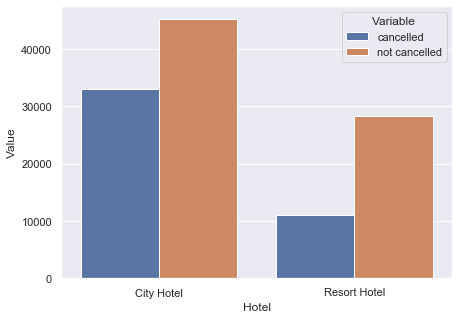

In [24]:
plot_barplot_cancelation_by_agg_cols(df=df, groupby_cols=['hotel'])

In [25]:
print(f"Frac of cancelled transac City {np.bincount(df1['is_canceled'])[1] / sum(np.bincount(df1['is_canceled']))}")
print(f"Frac of cancelled transac Resort {np.bincount(df2['is_canceled'])[1] / sum(np.bincount(df2['is_canceled']))}")
print(f"Frac of cancelled transac generally {np.bincount(df['is_canceled'])[1] / sum(np.bincount(df['is_canceled']))}")

Frac of cancelled transac City 0.2807968249122271
Frac of cancelled transac Resort 0.42205182036970657
Frac of cancelled transac generally 0.37476793105210265


**Conclusion 3**: There're much data for City Hotel (more customers there) and also there're tons of cancelled transactions for both hotel but especially for City Hotel

We see 41% percent of cancelled transaction in City hotel - that's a lot, 28% in Resort hotel and 37% in general

We want to forecast rolling 6 month revenue for hotels and to be honest and mostly correct it's better to use not cancelled transactions since hotels got money only for them or not? There're different cases and in some of them money can be returned after cancellation and in some of them can't. If we suppose that hotels earn money only from cancelled transactions then see below, otherwise we are able to use all transactions not splitting in groups of being canceled or not. Also there's this fact and using correct date: _booking date (better if hotels earned money on cancelled transactions too) and arrival date (if hotels dont earn money on canceled transaction and they get money like in a day of guests arrival)_. In real life we have more info but for now let's just keep it in mind

On the other hand the task asks to build confidence interval and of course we can make it like ordinary confidence interval but also i think it's quite a good point to predict revenue for non cancelled transactions and for both of them so in that case we are able to say smth like this "if demand is the same and there're no any canelled transaction so hotels would get amount of money M_1 but if we treat the demand another way and think cancellations could happen like now so we would get money M_2 where M_1 > M_2"

Especially it's important for aggregation (the task is to predict 6 month revenue) that i wrote above and not just for predict amount of 'adr' per transaction because in this way it'b be great to forecast probability of transaction being canceled so getting smth like Expected value in the case.

Also using cancelled trasactions is important for demand forecasting not revenue


Resort Hotel 2015


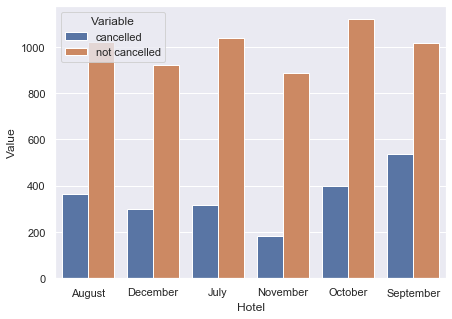

Resort Hotel 2016


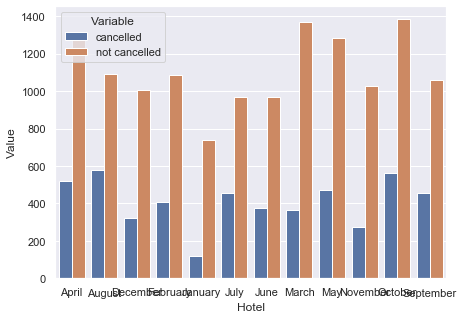

Resort Hotel 2017


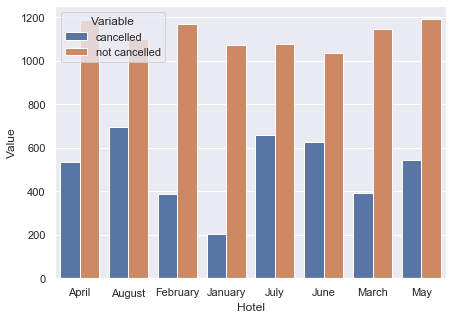

In [26]:
#let's check count cancelation by hotel and month
for year in df1['arrival_date_year'].unique():
    print(df1['hotel'].unique()[0], year)
    plot_barplot_cancelation_by_agg_cols(df=df1[df1['arrival_date_year']==year], groupby_cols=['arrival_date_month'])

City Hotel 2015


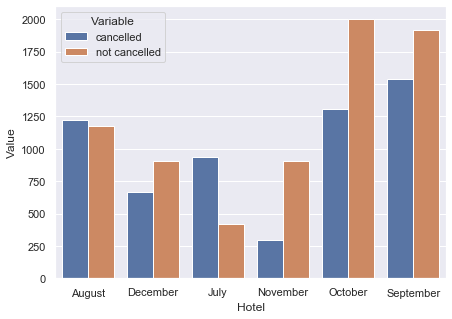

City Hotel 2016


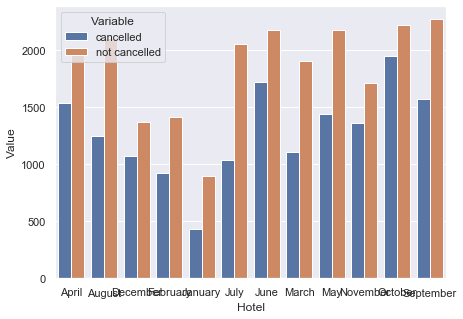

City Hotel 2017


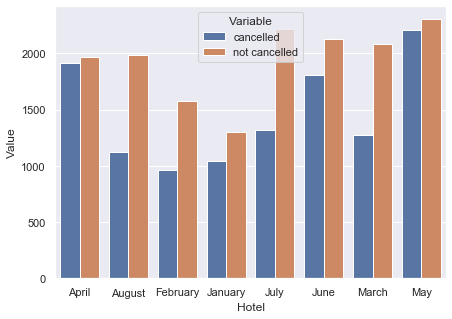

In [27]:
#let's check count cancelation by hotel and month
for year in df2['arrival_date_year'].unique():
    print(df2['hotel'].unique()[0], year)
    plot_barplot_cancelation_by_agg_cols(df=df2[df2['arrival_date_year']==year], groupby_cols=['arrival_date_month'])

Resort Hotel


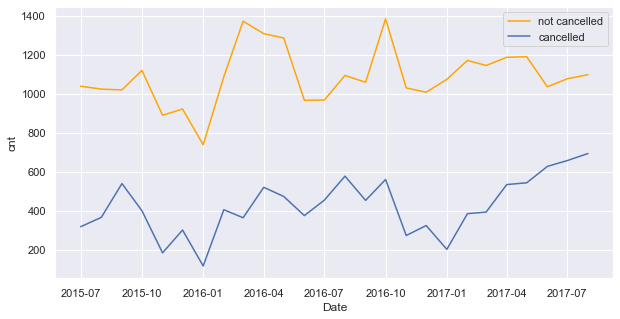

City Hotel


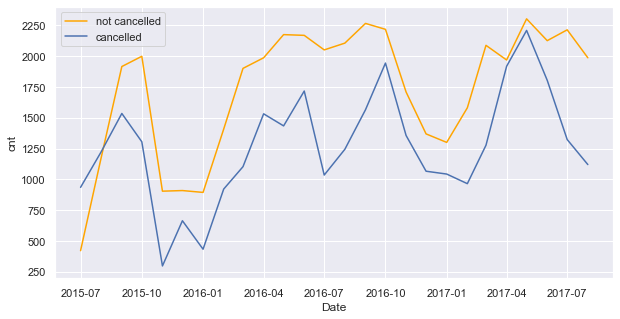

In [28]:
#plot sum of transactions (cancelled and non cancelled) per hotel for every month
df_distr_cancel = (
    df
    .groupby(['hotel', 'arrival_date_year', 'arrival_date_month', 'is_canceled'])
    .count()
    .iloc[:,0]
    .reset_index()
)
df_distr_cancel= df_distr_cancel.rename(columns={df_distr_cancel.columns[-1]: 'cnt'})
df_distr_cancel['dt'] = df_distr_cancel['arrival_date_year'].astype(str) + '-' + df_distr_cancel['arrival_date_month'] + '-1'
df_distr_cancel['dt'] = pd.to_datetime(df_distr_cancel['dt'])

for hotel in uniq_hotels:
    print(hotel)
    tmp = df_distr_cancel[df_distr_cancel['hotel'] == hotel]
    df_noncan_h = pd.DataFrame({'dt': tmp['dt'], 'cnt': tmp.loc[tmp['is_canceled'] == 0,'cnt']}).dropna(how='any')
    df_can_h = pd.DataFrame({'dt': tmp['dt'], 'cnt': tmp.loc[tmp['is_canceled'] == 1,'cnt']}).dropna(how='any')
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_noncan_h, x='dt', y='cnt', label='not cancelled', color='orange')
    sns.lineplot(data=df_can_h, x='dt', y='cnt', label='cancelled')
    plt.xlabel('Date')
    
    plt.legend()
    plt.show()

**Conclusion 4:** We can see that sum of not caceled and sum of canceled transactions per hotel by month looks similiar and they have common trend. That's interesting and it seems that growing demand meand increasing amount of cancelled transactions as well and vice versa. Good, at least we observe a normal case in my opinion

**One more hypothesis:** lead_time impacts on amount of cancelled transaction

Plot by year-month mean lead_time. Also we can make it via loop by year as above

Resort Hotel


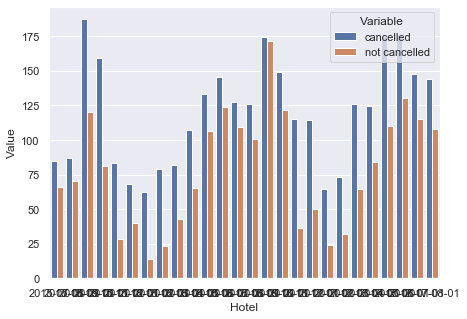

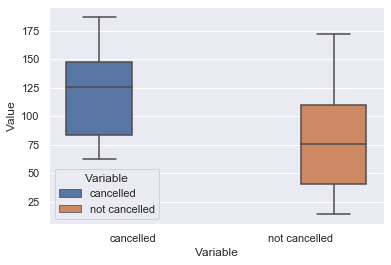

City Hotel


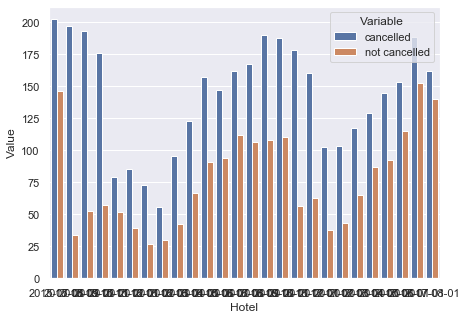

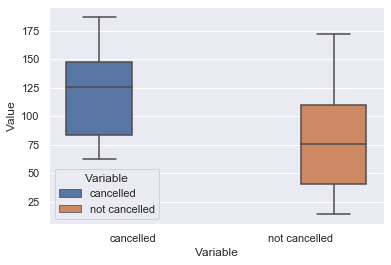

In [29]:
print(df1['hotel'].unique()[0])
tmp_df = plot_barplot_cancelation_by_agg_cols(df=df1, groupby_cols=['year_month'],
                                     col_to_agg='lead_time', method='mean', is_return_df=True)
sns.boxplot(data=tmp_df, hue='Variable', x='Variable', y='Value')
plt.show()

print(df2['hotel'].unique()[0])
plot_barplot_cancelation_by_agg_cols(df=df2, groupby_cols=['year_month'],
                                     col_to_agg='lead_time', method='mean', is_return_df=True)
sns.boxplot(data=tmp_df, hue='Variable', x='Variable', y='Value')
plt.show()

**Conclusion 5:**  We see that cancelled transactions have more lead_time on the average and if lead_time is big or small for not cancelled transactions than the same is for cancelled ones. That's interesting.

I would think that there's dependency on a month when reservations are made

Resort Hotel


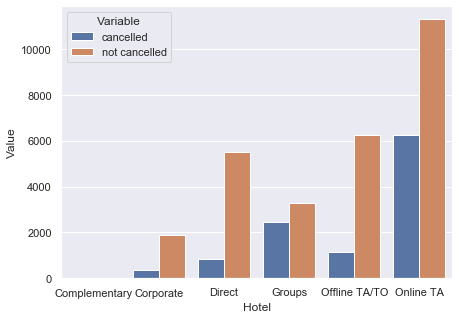

In [30]:
print(df1['hotel'].unique()[0])
plot_barplot_cancelation_by_agg_cols(df=df1, groupby_cols=['market_segment'], col_to_agg='is_canceled', method='count')

City Hotel


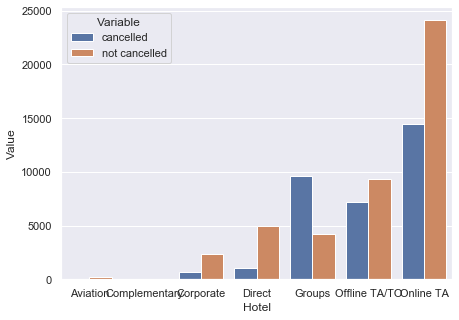

In [31]:
print(df2['hotel'].unique()[0])
plot_barplot_cancelation_by_agg_cols(df=df2, groupby_cols=['market_segment'], col_to_agg='is_canceled', method='count')

**Conclusion 6:** Most of booking transactions are made via 4 market segments: Direct, Groups, Offline TA/TO, Online TO and last 2 of them have essential amount across all others

Resort Hotel


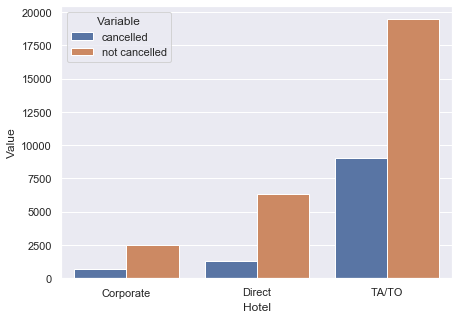

In [32]:
print(df1['hotel'].unique()[0])
plot_barplot_cancelation_by_agg_cols(df=df1, groupby_cols=['distribution_channel'],
                                     col_to_agg='is_canceled', method='count')

City Hotel


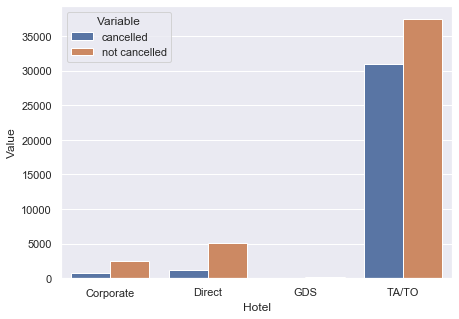

In [33]:
print(df2['hotel'].unique()[0])
plot_barplot_cancelation_by_agg_cols(df=df2, groupby_cols=['distribution_channel'],
                                     col_to_agg='is_canceled', method='count')

**Conclusion 7:** Travel Agents and Tour Operators are most popular Booking distribution channel and i guess it's expected since nowdays it's easy to book hotels online

Let's look on ADR columns since this is the main for us according to the goal of 6-month forecasting

Resort Hotel


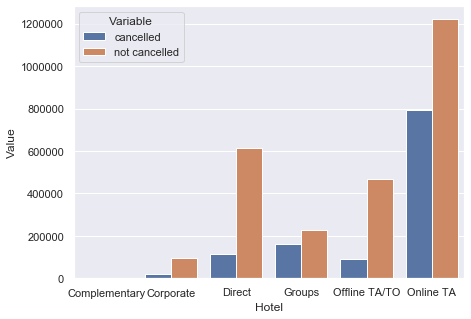

In [34]:
print(df1['hotel'].unique()[0])
plot_barplot_cancelation_by_agg_cols(df=df1, groupby_cols=['market_segment'], col_to_agg='adr', method='sum')

City Hotel


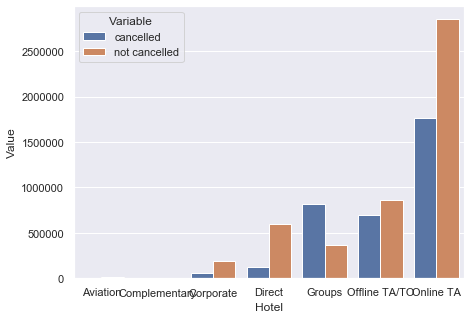

In [35]:
print(df2['hotel'].unique()[0])
plot_barplot_cancelation_by_agg_cols(df=df2, groupby_cols=['market_segment'], col_to_agg='adr', method='sum')

**Conclusion 8:** Here are the same 4 biggest market segments for ADR (average daily rate) and i think there's no much suprise too. So maybe it'd be quite okay to predict ADR per market segment and we can see that there's a goo opportunity to make in in online and offline  market segments since they are popular and they have much data and vice versa about others segments

Anyway our goal is to predict next 6 month revenue so it's better to keep all data than to drop even small segments because little amount of money is still money and it's better than nothing and also it will help to be more precise in our predictions

**Some time series analysis**

Now let's create 4 time series: 2 per one hotel and 1 is for all data and 1 for non cancelles transactions and check their plots.

We have tons of transactions and the task is about month revenue forecasting so I'll aggregate by day and then maybe by week and month

Also, as it's written above arrival_date or booking_date to use depends on type of getting monney by hotels.

Without loss of generality we may use 'arrival_date' further (as it's made before)

In [36]:
df_adr = pd.DataFrame({
    'dt': df['arrival_date'],
    'h1_part': df1.loc[df1['is_canceled'] == 0, 'money'],
    'h1_full': df1['money'],
    'h2_part': df2.loc[df2['is_canceled'] == 0, 'money'],
    'h2_full': df2['money'],
    
})
df_adr = (
    df_adr
    .groupby('dt')
    .sum()
    .reset_index()
    .sort_values('dt', ascending=True)
    .set_index('dt')
)
df_adr.head(3)

,h1_part,h1_full,h2_part,h2_full
dt,,,,
2015-07-01,15480.76,18367.26,12924.00,16273.50
2015-07-02,19438.44,24391.00,176.01,7658.51
2015-07-03,13965.09,20819.62,1791.89,2744.89


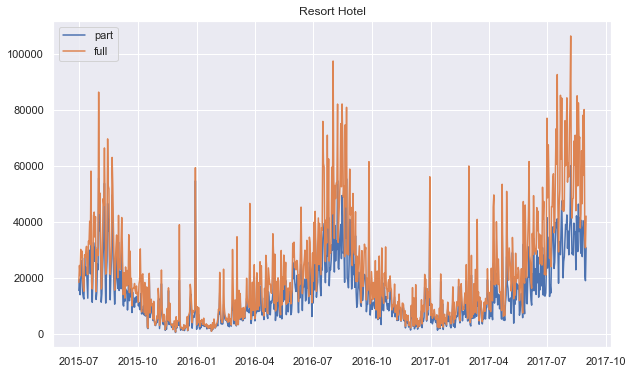

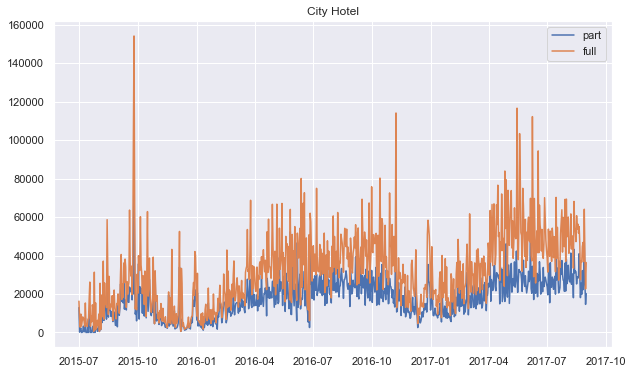

In [37]:
for i in range(2):
    #get ts for specific column
    ts_part = df_adr[f"h{i+1}_part"].dropna()
    ts_full = df_adr[f"h{i+1}_full"].dropna()
    #plot
    plt.figure(figsize=(10,6))
    plt.title(f"{uniq_hotels[i]}")
    plt.plot(ts_part.index, ts_part, label='part')
    plt.plot(ts_full.index, ts_full, label='full')
    plt.legend()
plt.show()


In [38]:
#basic outliers detection
df_adr.quantile(0.99), df_adr.max()

(h1_part    49392.0532
 h1_full    83513.8492
 h2_part    43239.8748
 h2_full    83100.6388
 Name: 0.99, dtype: float64,
 h1_part     64025.90
 h1_full    106332.36
 h2_part     82883.40
 h2_full    154186.40
 dtype: float64)

In [39]:
#basic outliers detection
df_adr.quantile(0.01), df_adr.min()

(h1_part    1339.7744
 h1_full    1745.8372
 h2_part      58.6500
 h2_full    2142.9600
 Name: 0.01, dtype: float64,
 h1_part    483.75
 h1_full    678.15
 h2_part      0.00
 h2_full    535.50
 dtype: float64)

**Conclusion 9:** we see common trend and some values looking like outliers on plots and using percentiles 1% and 99%.
Try to drop them and rebuild plots

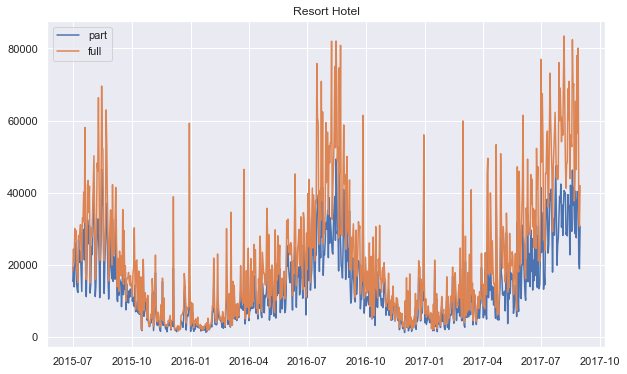

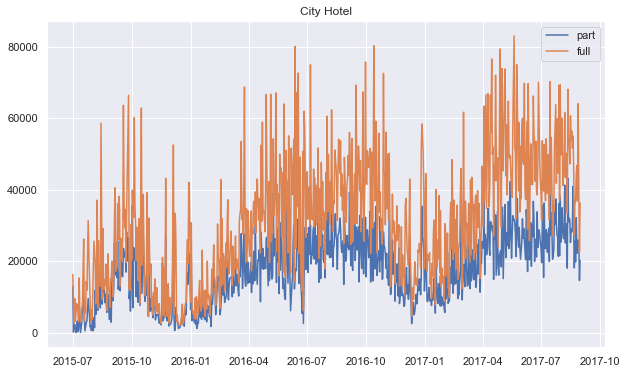

In [40]:
for i in range(2):
    #get ts for specific column
    ts_part = df_adr[f"h{i+1}_part"].dropna()
    ts_part = ts_part[(ts_part >= ts_part.quantile(0.01)) 
                      & (ts_part <= ts_part.quantile(0.99))]
    ts_full = df_adr[f"h{i+1}_full"].dropna()
    ts_full = ts_full[(ts_full >= ts_full.quantile(0.01)) 
                  & (ts_full <= ts_full.quantile(0.99))]

    #plot
    plt.figure(figsize=(10,6))
    plt.title(f"{uniq_hotels[i]}")
    plt.plot(ts_part.index, ts_part, label='part')
    plt.plot(ts_full.index, ts_full, label='full')
    plt.legend()
plt.show()


Looks much better so from now keep in mind about dropping outliers during building ML model

**Conclusion 10:** wee can see seasonality in our plots and it can be also usefull for creating several seosanal features for example that can help Boostinh models to forecast better or Prophet or other algorithms

From now let's go to build ML models to predict revenue

P.S. of course in real life we should take train, val, test and do these things on train and only after with learned parameters, rules etc repeat on val and test. It's important because we have to be able to do the same pipeline on inference (scoring date like today) and not getting overfitting. But for simplisity let's omit this step since it doesn't impact on our final task and pipeline

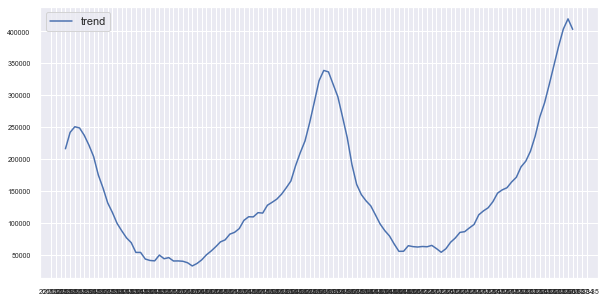

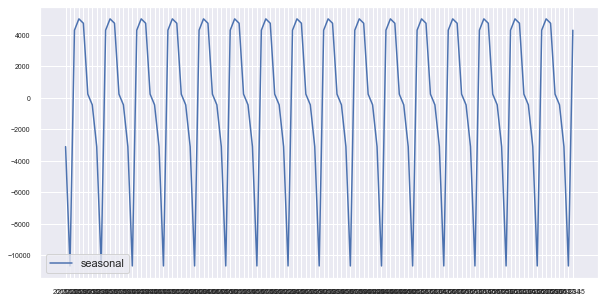

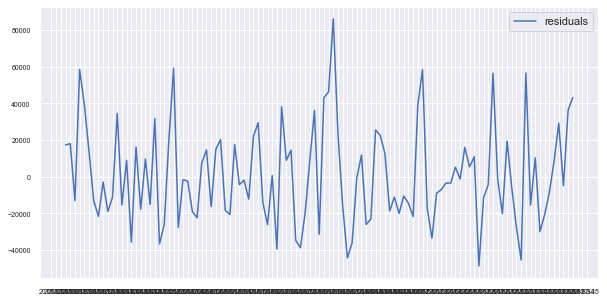

In [41]:
ts = df1.groupby('arrival_week_full').agg(y=('money', 'sum'))
plot_seasonal_decomposition(ts, period=7)

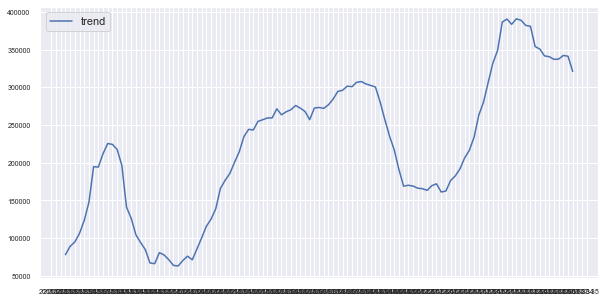

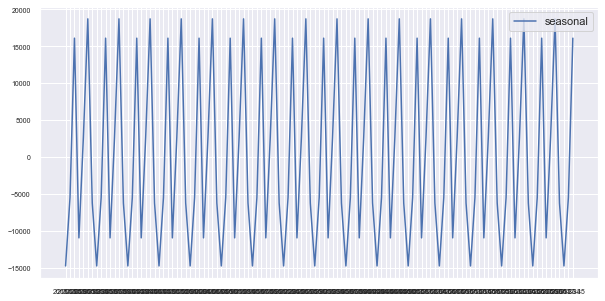

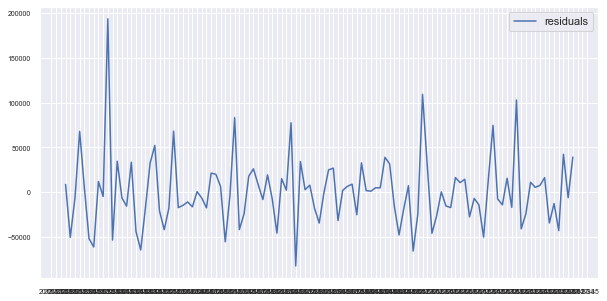

In [42]:
ts = df2.groupby('arrival_week_full').agg(y=('money', 'sum'))
plot_seasonal_decomposition(ts, period=7) #weekly data

**Conclusion 11:** See some trends in hotels data and seasonal part so it's a good point to consider in modeling further

In [43]:
##check via moving average 6-month revenue for non canceled transactions because we are going to predict exactply this
monthly_agg_money = df.query('is_canceled == 0').groupby(['hotel', 'arrival_month_full'])['money'].sum()
tmp = pd.DataFrame(monthly_agg_money.rolling(6).sum()).dropna().reset_index()
for hotel in uniq_hotels:
    print(hotel)
    print(tmp[tmp['hotel'] == hotel].describe())

Resort Hotel
              money
count  2.600000e+01
mean   2.698938e+06
std    1.170999e+06
min    1.131142e+06
25%    1.691280e+06
50%    2.543349e+06
75%    3.472103e+06
max    4.989179e+06
City Hotel
              money
count  2.100000e+01
mean   3.281081e+06
std    9.335627e+05
min    1.894039e+06
25%    2.504708e+06
50%    3.469508e+06
75%    3.968069e+06
max    4.835460e+06


In [44]:
df.to_csv(os.path.join('data', 'hotel_bookings_prepared.csv'), index=False)